In [1]:
!pip install transformers

     |████████████████████████████████| 1.9MB 5.6MB/s 
     |████████████████████████████████| 3.2MB 25.7MB/s 
     |████████████████████████████████| 890kB 36.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=a8a9cdd1ed28c017f711fd75d25402e905a01c0b85260249d4b24243674daa54
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import numpy as np
import os
import torch
import random
from google.colab import drive

# TEMPERATURE
import torch
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

# BERT
from tqdm.notebook import tqdm
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My\ Drive/Project-calibration-temperature_scaling

/content/drive/.shortcut-targets-by-id/1sbsGPIkVTMKDFQzt1fDYXAbOcHKiBL-9/Project-calibration-temperature_scaling


TEST WITH MNIST CONV 

Little architecture and Binary classification (hand digit is 8 or 1)


We first define the ModelWithTemperature Class for this model

In [11]:
class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader, loss_optim, training = True, all_logits = True):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss(all_logits=all_logits).cuda()
        mce_criterion = _MCELoss(all_logits=all_logits).cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece, before_avg_confidence_in_bin, before_accuracy_in_bin = ece_criterion(logits, labels)
        before_temperature_ece=before_temperature_ece.item()
        
        b1 = plt.bar( before_avg_confidence_in_bin, before_accuracy_in_bin, width = 0.05)
    
        print('Before temperature - NLL: %.3f, ECE/MCE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        if training :
          optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

          def eval():
              if loss_optim == "ECE" :
                loss,_,__ = ece_criterion(self.temperature_scale(logits), labels)
              if loss_optim == "MCE" :
                loss,_,__ = mce_criterion(self.temperature_scale(logits), labels)
              if loss_optim == "NLL" :
                loss= nll_criterion(self.temperature_scale(logits), labels)
              loss.backward()
              return loss
          optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece,  after_avg_confidence_in_bin, after_accuracy_in_bin = ece_criterion(self.temperature_scale(logits), labels)
        after_temperature_ece=after_temperature_ece.item()
        #print(after_avg_confidence_in_bin)
        #print(after_accuracy_in_bin)
        b2 = plt.bar( after_avg_confidence_in_bin, after_accuracy_in_bin, width = 0.05, color = 'green', alpha=0.5 )
        plt.plot(np.arange(0,1+1/10,1/10),np.arange(0,1+1/10,1/10), color='red')
        plt.xlabel("proba")
        plt.ylabel("accuracy")
        plt.legend([b1, b2], ['avant temperature_scaling', 'après temperature_scaling'])
        if training :
          plt.title("Probabilité en fonction de l'accuracy, Entrainement, loss: " + loss_optim)
        else :
          plt.title("Probabilité en fonction de l'accuracy, Validation, loss: " + loss_optim)
        plt.show()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE/MCE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self

We define the ECE and the MCE losses



In [6]:
class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).

    The input to this loss is the logits of a model, NOT the softmax scores.

    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:

    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |

    We then return a weighted average of the gaps, based on the number
    of samples in each bin

    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15, all_logits=True):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]
        self.all_logits = all_logits

    def forward(self, logits, labels):
        if self.all_logits:
          softmaxes = F.softmax(logits, dim=1)

          # for logits batch 3 and 5 classes we'll have 
          # predictions = torch.tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])
          predictions = torch.cat([torch.arange(logits.shape[1]) for i in range(logits.shape[0])]).to(device)

          # for a batch 3, 5 classes and labels [1, 0, 3] we'll have
          # labels = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3])
          labels = torch.cat([l * torch.ones(logits.shape[1]).to(device) for l in labels])

          # and then we put the probabilities for all batches together in a one vector
          # for a batch of size 3 and 5 classes, the confidence vectors we'll have 15 entries, as labels and predictions
          confidences = torch.flatten(softmaxes)
          accuracies = predictions.eq(labels)

        else:
           softmaxes = F.softmax(logits, dim=1)
           confidences, predictions = torch.max(softmaxes, 1)
           accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        PROB = []
        ACCU = []
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                PROB +=[avg_confidence_in_bin.cpu().item()]
                ACCU +=[accuracy_in_bin.cpu().item()]
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return (ece, PROB, ACCU)

In [7]:
class _MCELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).

    The input to this loss is the logits of a model, NOT the softmax scores.

    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:

    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |

    We then return a weighted average of the gaps, based on the number
    of samples in each bin

    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15, all_logits=True):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_MCELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]
        self.all_logits = all_logits

    def forward(self, logits, labels):
        if self.all_logits:
          softmaxes = F.softmax(logits, dim=1)

          # for logits batch 3 and 5 classes we'll have 
          # predictions = torch.tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])
          predictions = torch.cat([torch.arange(logits.shape[1]) for i in range(logits.shape[0])]).to(device)

          # for a batch 3, 5 classes and labels [1, 0, 3] we'll have
          # labels = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3])
          labels = torch.cat([l * torch.ones(logits.shape[1]).to(device) for l in labels])

          # and then we put the probabilities for all batches together in a one vector
          # for a batch of size 3 and 5 classes, the confidence vectors we'll have 15 entries, as labels and predictions
          confidences = torch.flatten(softmaxes)
          accuracies = predictions.eq(labels)

        else:
           softmaxes = F.softmax(logits, dim=1)
           confidences, predictions = torch.max(softmaxes, 1)
           accuracies = predictions.eq(labels)


        ece = torch.zeros(1, device=logits.device)
        PROB = []
        ACCU = []
        MCE = []
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                PROB +=[avg_confidence_in_bin.cpu().item()]
                ACCU +=[accuracy_in_bin.cpu().item()]
                MCE += [torch.abs(avg_confidence_in_bin - accuracy_in_bin)]

        return (max(MCE), PROB, ACCU)

Then we define the architecture and load the model

In [13]:
class classifier(nn.Module): 
    def __init__(self):
        super(classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=128, out_features=2)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size = 7)
        x = self.fc(torch.flatten(x, start_dim=1))
  
        return x

In [14]:
# loading pre-trained model
model_mnist = classifier()
model_filename = os.path.join("Saved_short/Saved_mnist", 'conv_mnist.pth')
if not os.path.exists(model_filename):
    raise RuntimeError('Cannot find file %s to load' % model_filename)
state_dict = torch.load(model_filename)

model_mnist.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
# loading validation iterator
valid_filename = os.path.join("Saved_short/Saved_mnist", 'test_mnist.pth')
if not os.path.exists(valid_filename):
    raise RuntimeError('Cannot find file %s to load' % valid_indices_filename)
valid_loader = torch.load(valid_filename)

Before temperature - NLL: 0.021, ECE/MCE: 0.004


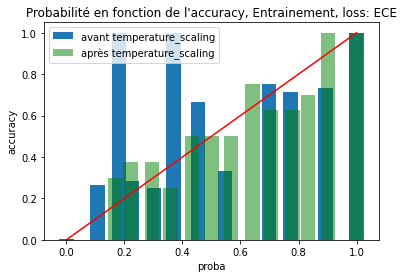

Optimal temperature: 1.443
After temperature - NLL: 0.019, ECE/MCE: 0.003


ModelWithTemperature(
  (model): classifier(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [16]:
# testing
model_with_temperature = ModelWithTemperature(model_mnist)
model_with_temperature.set_temperature(valid_loader, loss_optim = 'ECE', training = True, all_logits=True)

BERT FOR TEXT CLASSIFICATION

In [17]:
class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader, loss_optim = "NLL", training = True, all_logits=True):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss(all_logits=all_logits).cuda()
        mce_criterion = _MCELoss(all_logits=all_logits).cuda()
        self.model.eval()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for batch in valid_loader:
                
                batch = tuple(b.to(device) for b in batch)
                inputs = {'input_ids':      batch[0],
                          'attention_mask': batch[1],
                          'labels':         batch[2],
                        }       
                label = batch[2]
                logits = self.model(**inputs)[1]
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece, before_avg_confidence_in_bin, before_accuracy_in_bin = ece_criterion(logits, labels)
        before_temperature_ece=before_temperature_ece.item()
        
        b1 = plt.bar( before_avg_confidence_in_bin, before_accuracy_in_bin, width = 0.05)
    
        print('Before temperature - NLL: %.3f, ECE/MCE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        if training :
          optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

          def eval():
              if loss_optim == "ECE" :
                loss,_,__ = ece_criterion(self.temperature_scale(logits), labels)
              if loss_optim == "MCE" :
                loss,_,__ = mce_criterion(self.temperature_scale(logits), labels)
              if loss_optim == "NLL" :
                loss= nll_criterion(self.temperature_scale(logits), labels)
              loss.backward()
              return loss
          optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece,  after_avg_confidence_in_bin, after_accuracy_in_bin = ece_criterion(self.temperature_scale(logits), labels)
        after_temperature_ece=after_temperature_ece.item()
        #print(after_avg_confidence_in_bin)
        #print(after_accuracy_in_bin)
        b2 = plt.bar( after_avg_confidence_in_bin, after_accuracy_in_bin, width = 0.05, color = 'green', alpha=0.5 )
        plt.plot(np.arange(0,1+1/10,1/10),np.arange(0,1+1/10,1/10), color='red')
        plt.xlabel("proba")
        plt.ylabel("accuracy")
        plt.legend([b1, b2], ['avant temperature_scaling', 'après temperature_scaling'])
        if training :
          plt.title("Probabilité en fonction de l'accuracy, Entrainement, loss: " + loss_optim)
        else :
          plt.title("Probabilité en fonction de l'accuracy, Validation, loss: " + loss_optim)
        plt.show()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE/MCE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self

In [18]:
df = pd.read_csv('data/title_conference.csv')
df.head()

,Title,Conference
0,Innovation in Database Management: Computer Sc...,VLDB
1,High performance prime field multiplication fo...,ISCAS
2,enchanted scissors: a scissor interface for su...,SIGGRAPH
3,Detection of channel degradation attack by Int...,INFOCOM
4,Pinning a Complex Network through the Betweenn...,ISCAS


In [19]:
df['Conference'].value_counts()

ISCAS       864
INFOCOM     515
VLDB        423
WWW         379
SIGGRAPH    326
Name: Conference, dtype: int64

In [20]:
possible_labels = df.Conference.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'INFOCOM': 3, 'ISCAS': 1, 'SIGGRAPH': 2, 'VLDB': 0, 'WWW': 4}

In [21]:
df['label'] = df.Conference.replace(label_dict)

In [22]:
df.head()

,Title,Conference,label
0,Innovation in Database Management: Computer Sc...,VLDB,0
1,High performance prime field multiplication fo...,ISCAS,1
2,enchanted scissors: a scissor interface for su...,SIGGRAPH,2
3,Detection of channel degradation attack by Int...,INFOCOM,3
4,Pinning a Complex Network through the Betweenn...,ISCAS,1


In [23]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.3, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['Conference', 'label', 'data_type']).count()

Title
Conference label data_type       
INFOCOM    3     train        360
                 val          155
ISCAS      1     train        605
                 val          259
SIGGRAPH   2     train        228
                 val           98
VLDB       0     train        296
                 val          127
WWW        4     train        265
                 val          114

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=128, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=128, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [53]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model

In [54]:
batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [55]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 2

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [56]:
# METRICS
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [58]:
model = model.to(device)
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model.state_dict(), f'models/bert/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.9190824886194916
Validation loss: 0.7269166456349936
F1 Score (Weighted): 0.7454744435457079



Epoch 2
Training loss: 0.48674149439694026
Validation loss: 0.6177757282952864
F1 Score (Weighted): 0.7940368224292955



Before temperature - NLL: 0.618, ECE/MCE: 0.037


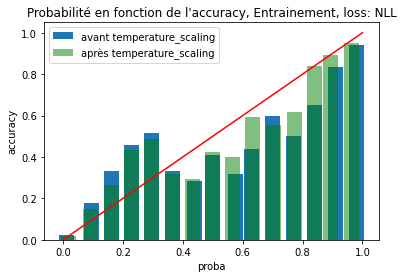

Optimal temperature: 1.218
After temperature - NLL: 0.589, ECE/MCE: 0.021


ModelWithTemperature(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [59]:
model_with_temperature = ModelWithTemperature(model)
model_with_temperature.set_temperature(dataloader_validation, loss_optim='NLL', training=True, all_logits = True)

Before temperature - NLL: 0.618, ECE/MCE: 0.037


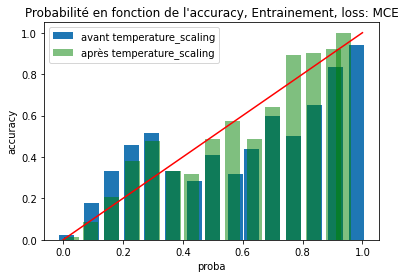

Optimal temperature: 1.500
After temperature - NLL: 0.598, ECE/MCE: 0.030


ModelWithTemperature(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [60]:
model_with_temperature = ModelWithTemperature(model)
model_with_temperature.set_temperature(dataloader_validation, loss_optim='MCE', training=True, all_logits = True)

Before temperature - NLL: 0.618, ECE/MCE: 0.037


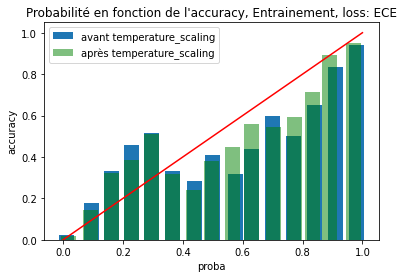

Optimal temperature: 1.146
After temperature - NLL: 0.594, ECE/MCE: 0.026


ModelWithTemperature(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [61]:
model_with_temperature_ = ModelWithTemperature(model)
model_with_temperature_.set_temperature(dataloader_validation, loss_optim='ECE', training=True, all_logits = True)

Before temperature - NLL: 0.618, ECE/MCE: 0.090


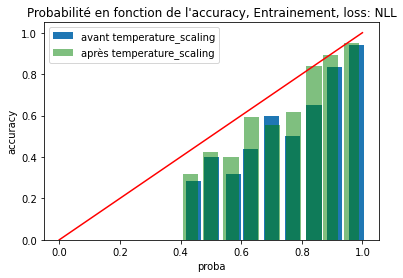

Optimal temperature: 1.218
After temperature - NLL: 0.589, ECE/MCE: 0.044


ModelWithTemperature(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [62]:
model_with_temperature = ModelWithTemperature(model)
model_with_temperature.set_temperature(dataloader_validation, loss_optim='NLL', training=True, all_logits = False)

Before temperature - NLL: 0.618, ECE/MCE: 0.037


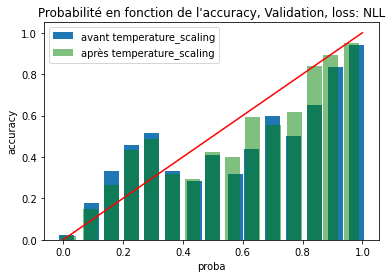

Optimal temperature: 1.218
After temperature - NLL: 0.589, ECE/MCE: 0.021


ModelWithTemperature(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [64]:
model_with_temperature.set_temperature(dataloader_validation, loss_optim='NLL', training=False, all_logits = True)

Before temperature - NLL: 0.883, ECE/MCE: 0.151


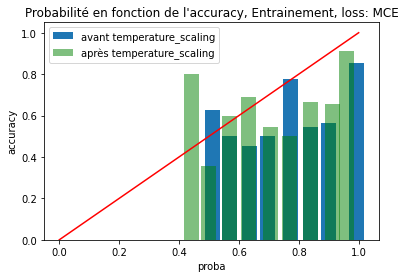

Optimal temperature: 1.544
After temperature - NLL: 0.653, ECE/MCE: 0.100


ModelWithTemperature(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [ ]:
model_with_temperature = ModelWithTemperature(model)
model_with_temperature.set_temperature(dataloader_validation, loss_optim='MCE', training=True, all_logits = False)

Before temperature - NLL: 0.890, ECE/MCE: 0.153


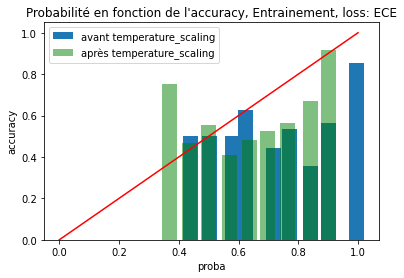

Optimal temperature: 2.051
After temperature - NLL: 0.599, ECE/MCE: 0.062


ModelWithTemperature(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [ ]:
model_with_temperature = ModelWithTemperature(model)
model_with_temperature.set_temperature(dataloader_validation, loss_optim='ECE', training=True, all_logits = False)

Before temperature - NLL: 0.890, ECE/MCE: 0.063


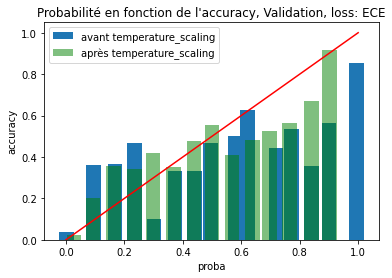

Optimal temperature: 2.051
After temperature - NLL: 0.599, ECE/MCE: 0.022


ModelWithTemperature(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [ ]:
model_with_temperature.set_temperature(dataloader_validation, loss_optim='ECE', training=False, all_logits = True)

TEMPERATURE SCALING